In [1]:
import os
import torch
import ot


os.chdir('..')
from lib.opt import *
from lib.gromov_test import *   

import numpy as np 
import numba as nb
import warnings
import time
from ot.backend import get_backend, NumpyBackend
from ot.lp import emd


In [2]:
@nb.njit(cache=True)
def tensor_dot_param(C1,C2,Lambda=0,loss='square_loss'):
    if loss=='square_loss':
        def f1(r1):
            return r1**2-2*Lambda
        def f2(r2):
            return r2**2
        def h1(r1):
            return r1
        def h2(r2):
            return 2*r2
    # else:
    #     warnings.warn("loss function error")

    fC1=f1(C1)
    fC2=f2(C2)
    hC1=h1(C1)
    hC2=h2(C2)
    
    return fC1,fC2,hC1,hC2

#@nb.njit(cache=True)
def tensor_dot_func(fC1,fC2,hC1,hC2,Gamma):
    #Gamma=np.ascontiguousarray(Gamma)
    n,m=Gamma.shape
    #Gamma_1=
    #Gamma_2=)
    C1=fC1.dot(Gamma.sum(1).reshape((-1,1))) #.dot(np.ones((1,m)))
    C2=Gamma.sum(0).dot(fC2.T)
    tensor_dot=(C1+C2)-hC1.dot(Gamma).dot(hC2.T) 
    return tensor_dot

#@nb.njit(cache=True)
def gwgrad_partial1(C1, C2, T,loss='square'):
    """Compute the GW gradient. Note: we can not use the trick in :ref:`[12] <references-gwgrad-partial>`
    as the marginals may not sum to 1.

    Parameters
    ----------
    C1: array of shape (n_p,n_p)
        intra-source (P) cost matrix

    C2: array of shape (n_u,n_u)
        intra-target (U) cost matrix

    T : array of shape(n_p+nb_dummies, n_u) (default: None)
        Transport matrix

    Returns
    -------
    numpy.array of shape (n_p+nb_dummies, n_u)
        gradient


    .. _references-gwgrad-partial:
    References
    ----------
    .. [12] Peyré, Gabriel, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.
    """
    #T=np.ascontiguousarray(T)
    if loss=='square':
        cC1 = np.dot(C1 ** 2 , np.dot(T, np.ones(C2.shape[0]).reshape(-1, 1)))
        cC2 = np.dot(np.dot(np.ones(C1.shape[0]).reshape(1, -1), T), C2 ** 2 )
        constC = cC1 + cC2
        A = -2*np.dot(C1, T).dot(C2.T)
        tens = constC + A
    elif loss=='dot':
        constC=0
        A = -2*np.dot(C1, T).dot(C2.T)
        tens = constC + A
    return tens 

@nb.njit(cache=True,fastmath=True)
def tensor_dot_orig(C1,C2,gamma,Lambda=0.0):
    n,m=C1.shape[0],C2.shape[0]
    tens=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            for i1 in range(n):
                for j1 in range(m):
                    M_iji1ji=(C1[i,i1]-C2[j,j1])**2-2*Lambda
                    tens[i,j]+=M_iji1ji*gamma[i1,j1]
    return tens


In [3]:
n=5000
X1=np.random.rand(n,2)
X2=np.random.rand(n,2)
C1=cost_matrix_d(X1,X1)
C2=cost_matrix_d(X2,X2)
gamma=np.random.rand(n,n)

deltaG=np.random.rand(n,n)

Lambda=10.0
fC1,fC2,hC1,hC2=tensor_dot_param(C1,C2,Lambda=Lambda)


%time M_circ_G1=gwgrad_partial1(C1, C2, gamma)-2*Lambda*gamma.sum()
%time M_circ_G2=tensor_dot_func(fC1,fC2,hC1,hC2,gamma)
#%time M_circ_G3=tensor_dot_orig(C1,C2,gamma,Lambda=Lambda)
print(np.linalg.norm(M_circ_G1-M_circ_G2))


CPU times: user 33.3 s, sys: 19.5 s, total: 52.8 s
Wall time: 848 ms
CPU times: user 30.7 s, sys: 7.29 s, total: 38 s
Wall time: 593 ms
0.0017386495550175327


In [4]:
G=np.random.rand(n,n)
deltaG=np.random.rand(n,n)
deltaG_sum=deltaG.sum()
reg=2*Lambda*np.sum(G)
M_circ_deltaG=gwgrad_partial1(C1, C2, deltaG)
M_circ_G=gwgrad_partial1(C1, C2, G)


%time a=np.sum(M_circ_deltaG*deltaG)-2*Lambda*deltaG_sum**2
%time b= 2 * (np.sum(M_circ_G * deltaG)-reg*deltaG_sum)



Mt_circ_G=tensor_dot_func(fC1,fC2,hC1,hC2,G)
Mt_circ_deltaG=tensor_dot_func(fC1,fC2,hC1,hC2,deltaG)

%time a1=np.sum(Mt_circ_deltaG*deltaG)

%time b1=2 * (np.sum(Mt_circ_G * deltaG))

print('a',a)
print('b',b)
print('a1',a1-a)
print('b1',b1-b1)


CPU times: user 670 ms, sys: 1.66 s, total: 2.33 s
Wall time: 36.4 ms
CPU times: user 571 ms, sys: 1.73 s, total: 2.3 s
Wall time: 36.7 ms
CPU times: user 735 ms, sys: 2.31 s, total: 3.05 s
Wall time: 47.7 ms
CPU times: user 582 ms, sys: 1.75 s, total: 2.33 s
Wall time: 36.4 ms
a -3100359118644546.0
b -6201959988326647.0
a1 -6.5
b1 0.0


In [ ]:
# run time 
import time
start=0
n_list=np.array([5,10,100,500,1000,2000,5000,10000])
#n_list=[5e3,1e4]
n_list=np.array(n_list,dtype=np.int64)
repeat_num=3
Lambda_list=np.array([0.2,1.0,10.0])
time_list=torch.load('result/alg/time_list.pt')
# time_list={}
# time_list['pgw_v1']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_v2']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_prim']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_sinkhorn']=np.zeros((len(n_list),len(Lambda_list),repeat_num))

for (n_idx,n) in enumerate(n_list[start:]):
    n_idx+=start
    print('n is',n)
    for (Lambda_idx,Lambda) in enumerate(Lambda_list):
        for repeat in range(repeat_num):
            print('repeat',repeat,end='\r')
            #print('repeat',repeat)
            np.random.seed(1)
            m=n+10
            X=np.random.rand(n,1)*2
            Y=np.random.rand(m,1)*2
            C1=cost_matrix_d(X,X)
            C2=cost_matrix_d(Y,Y)
            
            p=np.ones(n)
            p=p/m
            q=np.ones(m)
            q=q/m
            
            print('v2',end='\r')
            time1=time.time()
            Gamma2=partial_gromov_ver2(C1, C2, p, q, Lambda=Lambda, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_v2'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx ==0:
                print('time v2 is', time2-time1)
                #print('iter number ',iter_num)

           
            
            mass=np.sum(Gamma2)
            mass=np.min((mass,p.sum(),q.sum()))

            print('prim',end='\r')
            time1=time.time()
            Gamma3=partial_gromov_wasserstein(C1, C2, p, q, m=mass, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_prim'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx==0:
                print('time prim is', time2-time1)
                #print('iter_num is',iter_num)
            
            print('v1',end='\r')
            time1=time.time()
            Gamma1=partial_gromov_ver1(C1, C2, p, q, Lambda=Lambda, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_v1'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx ==0:
                print('time v1 is', time2-time1)
                #print('iter number ',iter_num)



            if n<2000:
                print('sinkhorn',end='\r')
                time1=time.time()
                ot.partial.entropic_partial_gromov_wasserstein(C1, C2, p, q, reg=0.1, m=mass, G0=None, numItermax=1000, tol=1e-05, log=False, verbose=False)
                time2=time.time()            
                time_list['pgw_sinkhorn'][n_idx,Lambda_idx,repeat]=time2-time1
            
            torch.save(time_list,'result/alg/time_list.pt')  

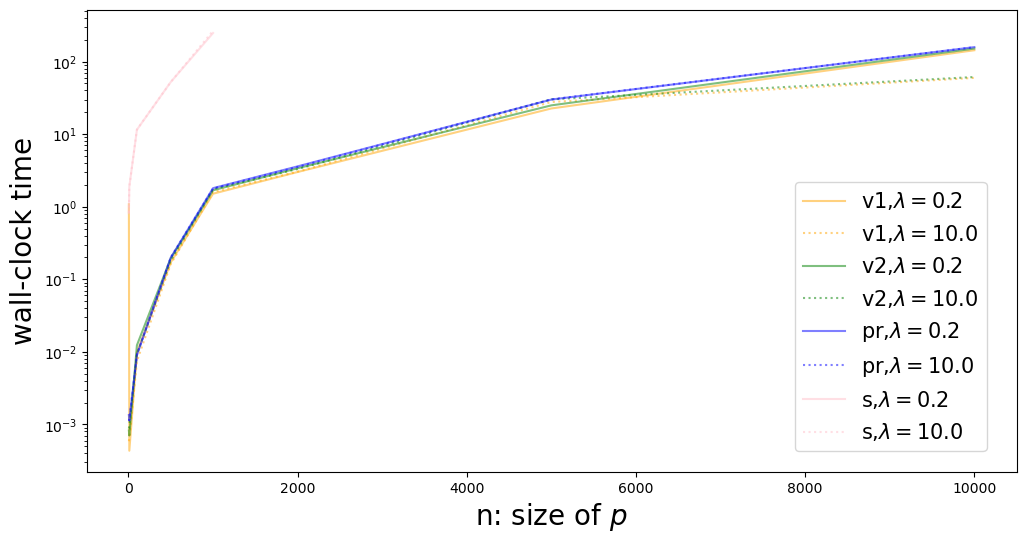

In [6]:
# wall clock time test 
import numpy as np
import torch
import matplotlib.pyplot as plt

n_list=np.array([5,10,100,500,1000,2000,5000,10000])
#n_list=[5e3,1e4]
n_list=np.array(n_list,dtype=np.int64)
repeat_num=3
Lambda_list=np.array([0.2,1.0,10.0])

time_list=torch.load('result/alg/time_list.pt')
time_v1=time_list['pgw_v1'] 
time_v2=time_list['pgw_v2']
time_prim=time_list['pgw_prim']
time_sinkhorn=time_list['pgw_sinkhorn']

time_v1_mean=np.mean(time_v1,2)
time_v2_mean=np.mean(time_v2,2)
time_prim_mean=np.mean(time_prim,2) 
time_sinkhorn_mean=np.mean(time_sinkhorn,2) 


fig, ax = plt.subplots(figsize=(12, 6))

# Plotting both error lists
for (method,color,time_mean) in zip(['v1','v2','pr','s'],['orange','green','blue','pink'],[time_v1_mean,time_v2_mean,time_prim_mean,time_sinkhorn_mean]):
    for (Lambda_idx,Lambda,style) in zip(np.array([0,2]),Lambda_list[[0,2]],['-',':']):
        if method !='s':
            ax.semilogy(n_list[:], time_mean[:,Lambda_idx],color=color,linestyle=style,alpha=0.5,label=method+f',$\lambda={Lambda}$')
        else:
            ax.semilogy(n_list[0:5], time_mean[0:5,Lambda_idx],color=color,alpha=0.5,linestyle=style,label=method+f',$\lambda={Lambda}$')


ax.set_xlabel('n: size of $p$',fontsize=20)
ax.set_ylabel('wall-clock time',fontsize=20)
#ax.set_title('Plot of Relative Error vs Size of $\mu$ for Different $\lambda$ Values')
ax.legend(bbox_to_anchor=(.75, 0.65),fontsize=15, loc="upper left")
plt.savefig('result/alg/time.png',dpi=200)
plt.savefig('result/alg/time.jpg',dpi=200)
plt.savefig('result/alg/time.pdf',dpi=200)
plt.show()
